In  addition  to what  achieved  at  step  A, the  system  should  now  be  able  to  detect  multiple  instance of  the 
same  product. Purposely, students may  deploy  local invariant  feature together with the GHT  (Generalized 
Hough Transform). More  precisely,  rather than relying on the usual R-Table,  the  object model acquired at 
training  time  should  now  consist  in  vectors  joining  all  the  features  extracted  in  the  model  image  to  their 
barycenter;  then,  at  run  time  all  the  image  features matched  with  respect  to the  model  would  cast  votes 
for the position of the barycenter by scaling appropriately the associated joining vectors (i.e. by the ratio of 
sizes between the matching features).

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os   

In [2]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

#define color scene
#scene_color = cv.imread(get_path_scene("e3.png"))

#plt.imshow(cv.cvtColor(scene_color, cv.COLOR_RGB2BGR))
#plt.show()

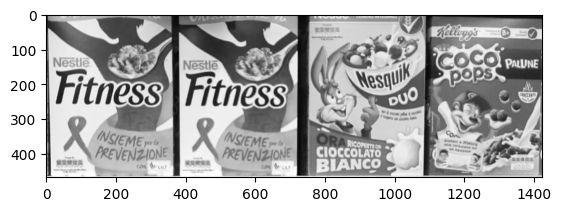

In [3]:
img_train = cv.imread(get_path_scene("m1.png"),0)
plt.imshow(img_train, cmap='gray',vmin=0,vmax=255)
plt.show()

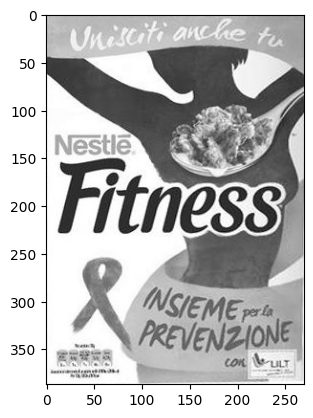

In [4]:
img_query = cv.imread(get_path_model(24), 0) # queryImage
plt.imshow(img_query, cmap='gray',vmin=0,vmax=255)
plt.show()

In [5]:
sift = cv.SIFT_create()
kp_query = sift.detect(img_query)

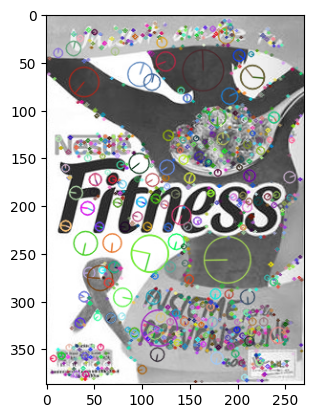

In [6]:
img_visualization = cv.drawKeypoints(img_query,kp_query,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

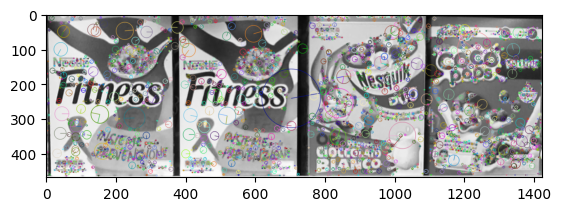

In [7]:
kp_train = sift.detect(img_train)

img=cv.drawKeypoints(img_train,kp_train,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img)
plt.show()

In [8]:
kp_query, des_query = sift.compute(img_query, kp_query)
kp_train, des_train = sift.compute(img_train, kp_train)

In [15]:
print(kp_train[0].pt)
print(len(kp_query))
print(len(kp_train))

(2.583493947982788, 170.43373107910156)
1065
3610


num of matches: 1065


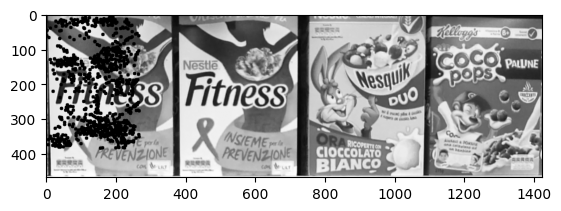

In [ ]:
FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des_query,des_train,k=2)
print("num of matches:", len(matches))


good = []
bad = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
    else:
        bad.append(m)

214
214


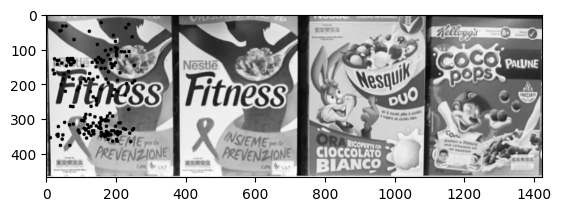

transformed_corners:
[[[  3.725376 -40.40209 ]]

 [[354.97052  -30.257292]]

 [[368.0236   466.9558  ]]

 [[ 14.890182 464.34335 ]]]


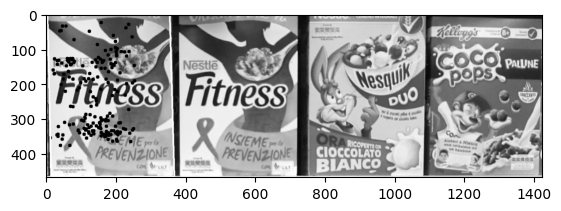

In [ ]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    src_pts_bad = np.float32([ kp_query[m.queryIdx].pt for m in bad ]).reshape(-1,1,2)

    print(len(src_pts))
    print(len(dst_pts))

    #draw points

    # for point in src_pts:
    #     x = point[0][0]
    #     y = point[0][1]
    #     cv.circle(img_train, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)
    # plt.imshow(img_train, "gray")
    # plt.show()


    #REPLACE
    # # Using RANSAC to estimate a robust homography. 
    # # It returns the homography M and a mask for the discarded points
    # M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    
    # # Mask of discarded point used in visualization
    # matchesMask = mask.ravel().tolist()
    
    # # Corners of the query image
    # h,w = img_query.shape
    # pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    
    # # Projecting the corners into the train image
    # dst = cv.perspectiveTransform(pts,M)
    
    # # Drawing the bounding box
    # img_train = cv.polylines(img_train,[np.int32(dst)],True,255,3, cv.LINE_AA)

    
    # Find homography (core of GHT)
    homography, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    
    # Map template corners to target image
    h, w = img_query.shape
    corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    transformed_corners = cv.perspectiveTransform(corners, homography)


    print("transformed_corners:")
    print(transformed_corners)
    
    # Draw bounding box in the target image
    target_with_box = cv.polylines(img_train.copy(), [np.int32(transformed_corners)], True, (255, 0, 0), 3)
    
    # Display the result
    plt.imshow(target_with_box, "gray")
    plt.show()

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

In [36]:
print(src_pts[0][0])

a = src_pts
print(len(a))
a[0]

[ 2.4816036 62.44909  ]
1065


array([[ 2.4816036, 62.44909  ]], dtype=float32)

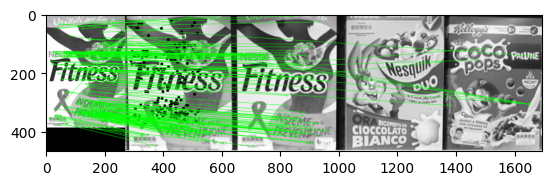

In [ ]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   #matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()